In [255]:
import numpy as np
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

# Reading Exam Files

Exam directories contain a collection of `<key>.txt` files, each corresponding to the measure of a flux debit accross a particular section. 

The `Exam(dir, *patterns)` constructor will load all files whose `<key>` matches one of the given patterns. 

(See [levels.csv]() for more details on those sections and the list of `<key>` values).

In [256]:
from exam import Exam

exam = Exam('I')

The returned `Exam` instance consists of a dictionnary of flux measures. 

A `Flux` instance represents either an arterial blood, veinous blood or a cerebro-spinal fluid flow:

```
    flux : { 
        type    : 'A' | 'V' | 'CSF',
        debit   : [float],
        surface : [float],
        volume  : [float],
        time    : [float],
        nom     : string,
        name    : string
    }
```

The following code will for instance plot all measured CSF fluxes.

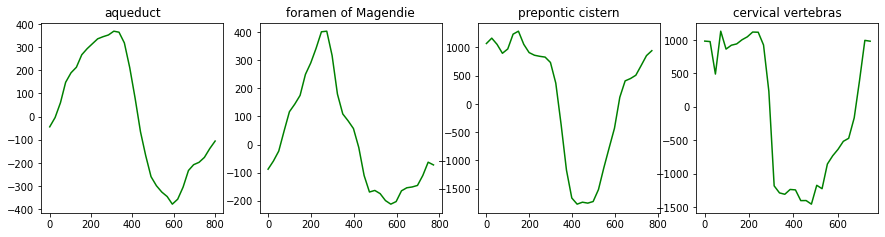

In [261]:
plt.figure(figsize=(15, 3.5))

exam2 = Exam('I').get('*')
csf = exam2.filter(lambda v, k: v.type == 'CSF')

i = 1
for flux, key in csf:
    plt.subplot(1, 4, i)
    plt.plot(flux.time, flux.debit, color="green")
    plt.title(flux.name)
    i+= 1

We can do the same with arterial blood fluxes:

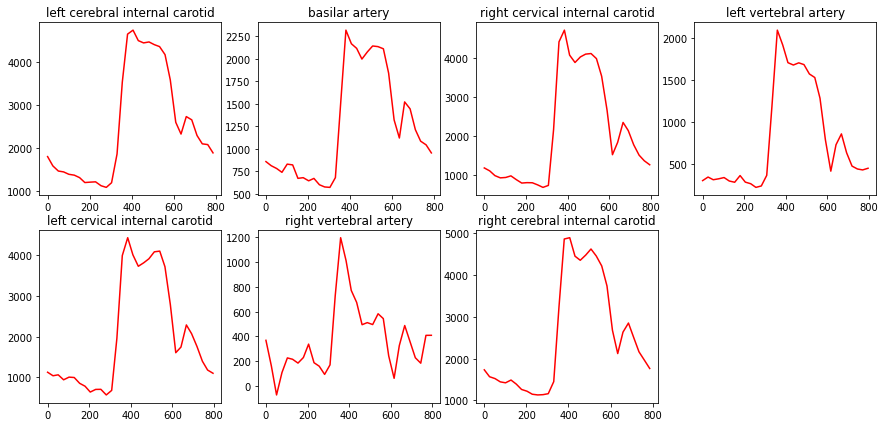

In [262]:
plt.figure(figsize=(15, 7))

arterial = exam2.filter(lambda v, k: v.type == 'A')

i = 1
for flux, key in arterial:
    plt.subplot(2, 4, i)
    plt.plot(flux.time, flux.debit, color="red")
    plt.title(flux.name)
    i+= 1
    

And with venous blood fluxes:

sinus-s: 1
coro_sinus_lat_g: -1
jugul-d: 1
sinus-d: 1
coro_sinus_s: -1
coro_sinus_d: -1
coro_sinus_lat_d: 1


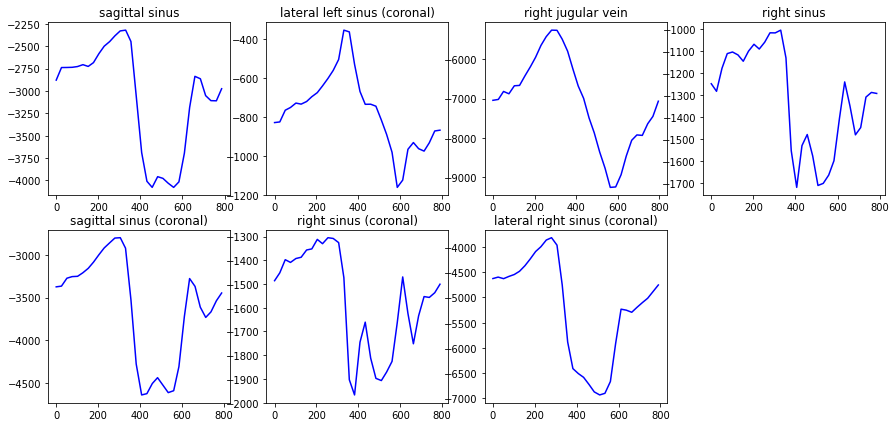

In [263]:
plt.figure(figsize=(15, 7))

venous = exam2.filter(lambda v, k: v.type == 'V')

i = 1
for flux, key in venous:
    plt.subplot(2, 4, i)
    sgn = -1 if key in ["coro_sinus_lat_g", "coro_sinus_s", "coro_sinus_d"] else 1
    print(f"{key}: {sgn}")
    flux.debit = sgn * flux.debit
    plt.plot(flux.time, flux.debit, color="blue")
    plt.title(flux.name)
    i+= 1

In [233]:
def resample(N, flux):
    
    def padSpectrum(curve):
        n = curve.shape[0]
        begin, end = int(np.floor((N-n)/2)), int(np.ceil((N-n)/2))
        F1 = np.fft.fftshift(fft(curve))
        F2 = (N/n) * np.pad(F1, (begin, end), constant_values=(0,0))
        return ifft(np.fft.ifftshift(F2))
    
    out = flux.filter(lambda v, k: k in ["type", "nom", "name"])
    
    for k in ['debit', 'volume', 'surface']:
        out[k] = padSpectrum(flux[k])
    
    out.time = np.linspace(0, flux.time[-1], N)
    
    return out

In [234]:
def plt_spectral(values, weights, width=0.2): 
    ax = plt.gca()
    height = np.abs(weights)
    color = [rgb_circle(a) for a in np.angle(weights)]
    ax.bar(values, height=height, width=width, color=color)
    
def rgb_circle(angle):
    O = np.array([.5, .5, .5])
    OX = (np.array([1, 0, .5]) - O) * np.sqrt(3) / 2
    OY = np.array([.75, .75, 0]) - O
    return O + np.cos(angle) * OX + np.sin(angle) * OY 

In [260]:
N = 8
extend = lambda f, k: resample(50, f)

arterial.map_(extend)
venous.map_(extend)
csf.map_(extend)

f1 = veinous['jugul-d']

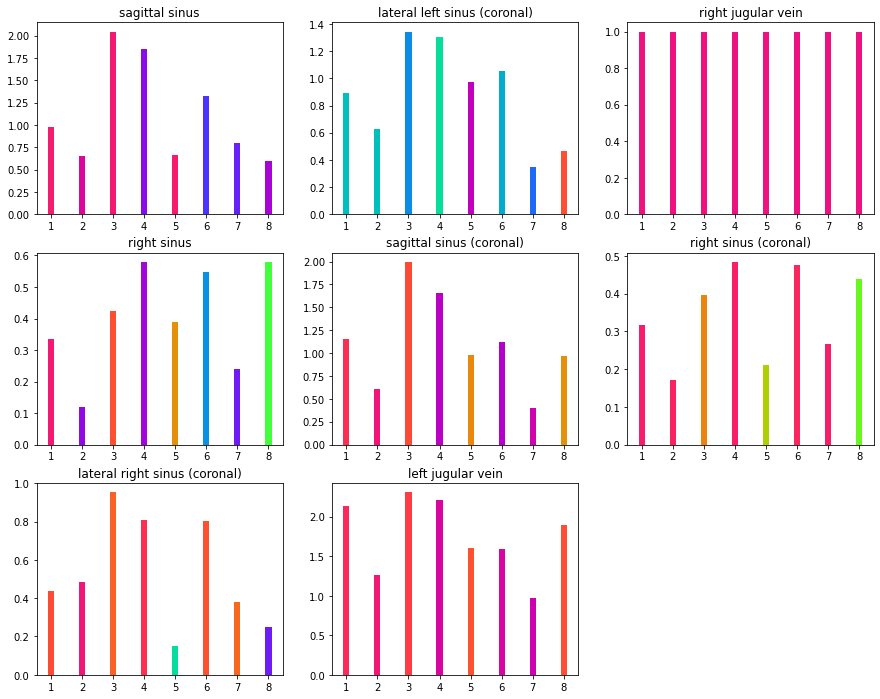

In [236]:

F1 = fft(f1.debit)
i=0

figure(figsize=(15, 12))
for f, k in veinous:
    F = fft(f.debit) 
    H = F/ (F1 + 1e-12)
    plt.subplot(3, 3, i+1)
    plt.title(f.name)
    plt_spectral(np.arange(1, N+1), H[1:N+1])
    i+=1

In [237]:
def plot_debits(dic, cols=4, height=3.5, color="red"):
    if shape == None:
        N = len(dic)
        shape = (N//cols + (1 if N % cols else 0), cols)
        figsize = (15, height * shape[0])
    plt.figure(figsize=figsize)
    
    i = 1
    for flux, key in dic:
        plt.subplot(shape[0], shape[1], i)
        plt.plot(flux.time, flux.debit, color=color)